In [1]:
import numpy as np 
import pandas as pd 
import re                                            
import os

import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from collections import Counter

In [2]:
# Path to clean data
cleaned_data_path = 'cleaned_enron_spam_data.csv'

# Check if the cleaned data already exists
if not os.path.exists(cleaned_data_path):
    # Load the original dataset
    data = pd.read_csv('enron_spam_data.csv')

    # Function to clean text
    def clean_text(text):
        if pd.notna(text):
            # Remove non-alphanumeric characters
            text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
            # Convert text to lower case
            text = text.lower()
            # Reduce multiple spaces to a single space
            text = re.sub(r'\s+', ' ', text)
        return text

    # Apply the clean_text function to 'Subject' and 'Message' columns
    data['Subject'] = data['Subject'].apply(clean_text)
    data['Message'] = data['Message'].apply(clean_text)

    # Overwrite the original data file
    data.to_csv(cleaned_data_path, index=False)
else:
    data = pd.read_csv(cleaned_data_path)
    print("Cleaned data loaded successfully.")

Cleaned data loaded successfully.


In [6]:
# Split the 'Subject' and 'Message' into lists of words, or use an empty list if the value is missing
data['Subject'] = data['Subject'].apply(lambda x: x.split() if isinstance(x, str) else [])
data['Message'] = data['Message'].apply(lambda x: x.split() if isinstance(x, str) else [])

# Display the updated DataFrame to verify the changes
data.head()


,Message ID,Subject,Message,Spam/Ham,Date
0,0,"[christmas, tree, farm, pictures]",[],ham,1999-12-10
1,1,"[vastar, resources, inc]","[gary, production, from, the, high, island, la...",ham,1999-12-13
2,2,"[calpine, daily, gas, nomination]","[calpine, daily, gas, nomination, 1, doc]",ham,1999-12-14
3,3,"[re, issue]","[fyi, see, note, below, already, done, stella,...",ham,1999-12-14
4,4,"[meter, 7268, nov, allocation]","[fyi, forwarded, by, lauri, a, allen, hou, ect...",ham,1999-12-14


In [9]:
# Initialize a Counter to hold word frequencies
vocabulary = Counter()

# Iterate over each list in the 'Message' column
for message_list in data['Message']:
    vocabulary.update(message_list)

# Display the size of the vocabulary and some sample words with their counts
print(f"Vocabulary Size: {len(vocabulary)}")

# Print the 10 most common words
for word, count in vocabulary.most_common(10):
    print(f"{word}: {count}")


Vocabulary Size: 154326
the: 288613
to: 210628
and: 155693
of: 147052
a: 116803
in: 105622
for: 80834
you: 80025
is: 70751
this: 63159


In [10]:
# Convert list of words back to string for vectorization
data['Message_str'] = data['Message'].apply(lambda x: ' '.join(x))
data.head()

,Message ID,Subject,Message,Spam/Ham,Date,Message_str
0,0,"[christmas, tree, farm, pictures]",[],ham,1999-12-10,
1,1,"[vastar, resources, inc]","[gary, production, from, the, high, island, la...",ham,1999-12-13,gary production from the high island larger bl...
2,2,"[calpine, daily, gas, nomination]","[calpine, daily, gas, nomination, 1, doc]",ham,1999-12-14,calpine daily gas nomination 1 doc
3,3,"[re, issue]","[fyi, see, note, below, already, done, stella,...",ham,1999-12-14,fyi see note below already done stella forward...
4,4,"[meter, 7268, nov, allocation]","[fyi, forwarded, by, lauri, a, allen, hou, ect...",ham,1999-12-14,fyi forwarded by lauri a allen hou ect on 12 1...


In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Message_str'], data['Spam/Ham'], test_size=0.25, random_state=42)  # Ensures a reproducible split

In [12]:
# %%time
# # Vectorize the text data into a Boolean feature matrix, considering only words that appear at least 5 times
# vectorizer = CountVectorizer(binary=True)
# X_train_transformed = vectorizer.fit_transform(X_train)
# features = vectorizer.get_feature_names_out()

# # Label encoding
# y_train_encoded = (y_train == 'spam').astype(int)

# # # Compute mutual information between each feature and the labels
# # mi_scores = mutual_info_classif(X_train_transformed, y_train_encoded, discrete_features=True)

# # # Create a Series to view feature scores
# # mi_scores_series = pd.Series(mi_scores, index=features)

# # # Sort the features by their mutual information score in descending order
# # sorted_features = mi_scores_series.sort_values(ascending=False)


In [19]:
# Select top M features
# M = 5000
# top_features = sorted_features.head(M)

# Retrieve the vocabulary of the top M most informative words
# top_vocab = top_features.index.to_numpy()
# If you need to load this vocabulary later, you can use:
top_vocab = np.load('top_vocab.npy', allow_pickle=True)
# print("Top words in the vocabulary:")
print(top_vocab[:25])  # Print the top 25 words to check

['enron' 'cc' 'pm' '2001' 'ect' 'subject' 'hou' 'forwarded' '2000' 'vince'
 'thanks' 'am' 'attached' '713' 'http' 'kaminski' 'houston' 'questions'
 'let' 'me' 'louise' '01' 'corp' 'gas' '02']


In [21]:
%%time
# Vectorize the text data into a Boolean feature matrix, considering only words that appear at least 5 times
vectorizer = CountVectorizer(binary=True, min_df=5, vocabulary=top_vocab)
X_train_transformed = vectorizer.fit_transform(X_train)
features = vectorizer.get_feature_names_out()

# Label encoding
y_train_encoded = (y_train == 'spam').astype(int)

CPU times: user 1.69 s, sys: 53.2 ms, total: 1.74 s
Wall time: 1.87 s


In [22]:
# Calculate category counts from the training labels only
category_counts = y_train.value_counts()

# Calculate the total number of messages in the training set
total_messages_train = len(y_train)

# Calculate the a priori probabilities based on training data
p_ham = category_counts['ham'] / total_messages_train
p_spam = category_counts['spam'] / total_messages_train

# Print the probabilities based on the training set
print(f"Probability of Ham (based on training data): {p_ham}")
print(f"Probability of Spam (based on training data): {p_spam}")

Probability of Ham (based on training data): 0.49143828844861
Probability of Spam (based on training data): 0.5085617115513901


In [23]:
# Manually calculating probability of each feature given a class
def calculate_feature_probabilities(X, y):
    n_samples, n_features = X.shape
    # Initialize dictionaries to hold probabilities
    spam_probabilities = np.zeros(n_features)
    ham_probabilities = np.zeros(n_features)
    
    # Total messages in each class
    spam_count = np.sum(y == 1)
    ham_count = np.sum(y == 0)
    
    # Calculate probabilities for each feature
    for feature_index in range(n_features):
        # Count occurrences of each feature in spam and ham messages
        feature_spam_count = np.sum(X[y == 1, feature_index])
        feature_ham_count = np.sum(X[y == 0, feature_index])
        
        # Apply Laplace smoothing
        spam_probabilities[feature_index] = (feature_spam_count + 1) / (spam_count + 2)
        ham_probabilities[feature_index] = (feature_ham_count + 1) / (ham_count + 2)
    
    return spam_probabilities, ham_probabilities

# Prediction function using the Naive Bayes formula
def predict(X, spam_probabilities, ham_probabilities, p_spam, p_ham):
    n_samples, n_features = X.shape
    predictions = []
    for i in range(n_samples):
        # Log probabilities to avoid underflow
        spam_log_prob = np.log(p_spam)
        ham_log_prob = np.log(p_ham)
        
        for feature_index in range(n_features):
            if X[i, feature_index] == 1:  # Feature is present
                spam_log_prob += np.log(spam_probabilities[feature_index])
                ham_log_prob += np.log(ham_probabilities[feature_index])
            else:  # Feature is absent
                spam_log_prob += np.log(1 - spam_probabilities[feature_index])
                ham_log_prob += np.log(1 - ham_probabilities[feature_index])
        
        # Compare probabilities
        if spam_log_prob > ham_log_prob:
            predictions.append(1)  # Spam
        else:
            predictions.append(0)  # Ham
            
    return predictions

In [24]:
X_train_transformed = X_train_transformed.toarray()
y_train_encoded = y_train_encoded.to_numpy() 

In [25]:
# Calculate feature probabilities
spam_probabilities, ham_probabilities = calculate_feature_probabilities(X_train_transformed, y_train_encoded)

### Train Evaluation

In [26]:
# Prediction (using a subset of data to demonstrate)
predictions = predict(X_train_transformed, spam_probabilities, ham_probabilities, p_spam, p_ham)

# Calculate accuracy
accuracy = accuracy_score(y_train_encoded, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_train_encoded, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Detailed classification report
class_report = classification_report(y_train_encoded, predictions, target_names=['Ham', 'Spam'])
print("Classification Report:")
print(class_report)

Accuracy: 0.9420
Confusion Matrix:
[[11056  1371]
 [   96 12764]]
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.89      0.94     12427
        Spam       0.90      0.99      0.95     12860

    accuracy                           0.94     25287
   macro avg       0.95      0.94      0.94     25287
weighted avg       0.95      0.94      0.94     25287



### Test Evaluation

In [27]:
# Transform the test data
X_test_transformed = vectorizer.transform(X_test).toarray()

# Predict on the test data
test_predictions = predict(X_test_transformed, spam_probabilities, ham_probabilities, p_spam, p_ham)

# Calculate accuracy and other metrics for the test set
test_accuracy = accuracy_score((y_test == 'spam').astype(int), test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Test set confusion matrix
test_conf_matrix = confusion_matrix((y_test == 'spam').astype(int), test_predictions)
print("Test Confusion Matrix:")
print(test_conf_matrix)

# Test set classification report
test_class_report = classification_report((y_test == 'spam').astype(int), test_predictions, target_names=['Ham', 'Spam'])
print("Test Classification Report:")
print(test_class_report)


Test Accuracy: 0.9394
Test Confusion Matrix:
[[3647  471]
 [  40 4271]]
Test Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.89      0.93      4118
        Spam       0.90      0.99      0.94      4311

    accuracy                           0.94      8429
   macro avg       0.94      0.94      0.94      8429
weighted avg       0.94      0.94      0.94      8429



Text(0, 0.5, 'True Labels')

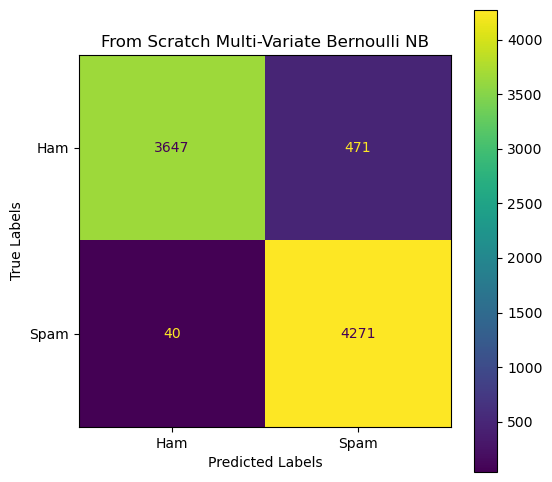

In [40]:
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
# Display the confusion matrix with sklearn's ConfusionMatrixDisplay
classes = ['Ham', 'Spam']
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(6, 6))
sklearn_disp.plot(ax=ax, cmap='viridis', values_format='g')  # 'g' for generic number format
ax.set_title(f'{"From Scratch Multi-Variate Bernoulli"} NB')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

## Top Method words = .9394 Test Bernoulli